# **Résolution du Problème du Voyageur de Commerce avec Python (Branch and Bound) , PPV , 2OP**


# **Introduction**


Le problème du voyageur de commerce est un problème NP-complet classique en optimisation combinatoire où l'objectif est de trouver le chemin le plus court qui visite chaque ville exactement une fois et retourne à la ville de départ. Dans ce notebook, nous abordons ce problème en utilisant
branch and bound , plus proche voisin (PPV) et 2OP



# **Importation des modules et des données :**
Dans cette section, nous importons les modules nécessaires à l'exécution de notre code. Nous utilisons xml.etree.ElementTree, qui est une bibliothèque Python destinée à la manipulation et à l'analyse de documents XML, ainsi que numpy, scipy et matplotlib pour effectuer des calculs et visualiser les résultats.

In [24]:
import os
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
maxsize = float('inf')
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import time

# **Chargement des Données et Construction de la Matrice des Distances :**

---


Dans cette partie du code, nous chargeons les données à partir d'un fichier XML qui contient les informations sur les villes et leurs coordonnées. Nous utilisons la bibliothèque xml.etree.ElementTree pour parcourir le fichier XML et extraire ces données nécessaires. Après avoir initialisé une matrice des distances de taille appropriée, nous parcourons chaque nœud dans le fichier XML pour obtenir les informations sur les arêtes connectées à chaque ville. Nous utilisons ces informations pour remplir la matrice des distances, où chaque élément de la matrice représente le coût pour se rendre d'une ville à une autre. Enfin, nous affichons la matrice des distances pour vérifier que les données ont été correctement chargées. Cette étape est cruciale car elle prépare les données nécessaires pour résoudre le problème du voyageur de commerce.

In [25]:
# Charger le fichier XML
tree = ET.parse('data.xml')
root = tree.getroot()

# Initialiser la matrice des distances
nombre_villes = 17
matrice_distances = np.zeros((nombre_villes, nombre_villes))

# Remplir la matrice des distances
for i, vertex in enumerate(root.find('graph').findall('vertex')):
    for edge in vertex.findall('edge'):
        j = int(edge.text)  # L'indice de la ville de destination
        cost = float(edge.get('cost'))  # Le coût pour se rendre à cette ville
        matrice_distances[i, j] = cost


# Afficher la matrice des distances
print(matrice_distances)

[[ 0. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.]
 [10.  0. 18. 25. 35. 45. 55. 50. 40. 30. 20. 25. 40. 50. 55. 60. 65.]
 [15. 18.  0. 17. 22. 35. 42. 47. 60. 55. 50. 45. 40. 35. 30. 27. 20.]
 [20. 25. 17.  0. 14. 27. 30. 37. 42. 49. 55. 60. 65. 70. 75. 80. 85.]
 [25. 35. 22. 14.  0. 12. 20. 28. 30. 35. 40. 45. 50. 55. 60. 65. 70.]
 [30. 45. 35. 27. 12.  0. 15. 22. 25. 30. 35. 40. 45. 50. 55. 60. 65.]
 [35. 55. 42. 30. 20. 15.  0. 10. 18. 25. 30. 35. 40. 45. 50. 55. 60.]
 [40. 50. 47. 37. 28. 22. 10.  0. 14. 20. 25. 30. 35. 40. 45. 50. 55.]
 [45. 40. 60. 42. 30. 25. 18. 14.  0. 12. 17. 22. 27. 32. 37. 42. 47.]
 [50. 30. 55. 49. 35. 30. 25. 20. 12.  0. 14. 17. 20. 25. 30. 35. 40.]
 [55. 20. 50. 55. 40. 35. 30. 25. 17. 14.  0. 10. 15. 20. 25. 30. 35.]
 [60. 25. 45. 60. 45. 40. 35. 30. 22. 17. 10.  0. 12. 15. 20. 25. 30.]
 [65. 40. 40. 65. 50. 45. 40. 35. 27. 20. 15. 12.  0. 10. 15. 20. 25.]
 [70. 50. 35. 70. 55. 50. 45. 40. 32. 25. 20. 15. 10.  0. 10. 15. 20.]
 [75. 

# **Calcul de la Borne Inférieure :**
Cette fonction calcule une borne inférieure pour le noeud (ou ville) actuel. Voici une explication des étapes impliquées :

**Calcul du coût minimum de départ**
- Si villes_restantes n'est pas vide, cela signifie qu'il reste des villes à visiter. Dans ce cas, la variable min_cout_depart est définie comme étant le coût minimum pour se déplacer de la ville_courante vers l'une des villes restantes. Cela est calculé en prenant le minimum des distances de la ville_courante vers chaque ville restante.

- Sinon, si villes_restantes est vide, cela signifie que toutes les villes ont été visitées, donc la fonction retourne simplement le coût de retour à la ville de départ (indice 0 dans la matrice).

**Calcul de la borne inférieure**
La fonction retourne ensuite simplement le coût minimum de départ calculé précédemment, qui sert d'estimation de la borne inférieure pour le nœud actuel.




In [26]:
def calculer_borne_inf_pour_noeud(matrice, ville_courante, villes_restantes):
    # Coût minimum pour partir de la ville courante vers une des villes restantes
    if villes_restantes:
        min_cout_depart = min(matrice[ville_courante][j] for j in villes_restantes)
    else:
        # Si il n'y a pas de villes restantes, on considère le retour vers la ville de départ (0)
        return matrice[ville_courante][0]

    # Estimation simple de la borne inférieure pour un noeud
    return min_cout_depart

# **Algorithme du Plus Proche Voisin  :**
Cette fonction implémente l'algorithme du plus proche voisin, une heuristique couramment utilisée pour obtenir une solution initiale au problème du voyageur de commerce. À chaque étape, l'algorithme choisit la ville non visitée la plus proche de la dernière ville visitée et l'ajoute au chemin parcouru. Cette approche itérative garantit que chaque ville est visitée une fois et que le chemin final forme un cycle. Le coût total du chemin est calculé en additionnant les distances entre les villes successives. Cette méthode fournit une solution initiale rapide et raisonnablement bonne, bien qu'elle ne garantisse pas la meilleure solution possible.

In [27]:
def plus_proche_voisin(matrice_distances):
    N = len(matrice_distances)
    visite = [False] * N
    parcours = [0]  # On commence par la première ville
    visite[0] = True
    cout_total = 0
    # Boucler sur toutes les villes restantes
    for _ in range(1, N):
        derniere = parcours[-1]
        plus_proche = -1
        distance_min = maxsize
        # Parcourir toutes les villes non visitées pour trouver le plus proche voisin
        for i in range(N):
            if not visite[i] and 0 < matrice_distances[derniere][i] < distance_min:
                distance_min = matrice_distances[derniere][i]
                plus_proche = i
        # Ajouter le plus proche voisin au chemin parcouru et mettre à jour les variables
        parcours.append(plus_proche)
        visite[plus_proche] = True
        cout_total += distance_min  # Mettre à jour le coût total
    # Retour à la première ville
    cout_total += matrice_distances[parcours[-1]][parcours[0]]
    parcours.append(parcours[0])  # Ajouter la ville de départ à la fin pour compléter le cycle
    return parcours, cout_total

# **Algorithme du 2 OP :**
Ce code implémente l'algorithme 2-OPT pour résoudre le problème du voyageur de commerce (TSP). L'algorithme commence par générer un chemin initial aléatoire, puis il itère à travers toutes les paires de villes non consécutives dans le chemin et teste si l'échange de ces paires améliore le coût total du chemin. Il continue à effectuer ces échanges tant qu'il y a des améliorations possibles. Une fois terminé, il renvoie le meilleur chemin trouvé avec son coût. En résumé, l'algorithme cherche à optimiser le trajet parcouru par le voyageur de commerce en réorganisant le chemin initial pour minimiser la distance totale parcourue.

In [40]:
# d'abord on genere le chemin intial
def Initialiser_Chemin(matrices_distances) :
    chemin_initial = list(range(len(matrice_distances)))
    np.random.shuffle(chemin_initial)
    chemin_initial.append(chemin_initial[0])
    return chemin_initial

chemin_initial = Initialiser_Chemin(matrice_distances)

# code 2-OPT
def calculer_cout(matrice_distances, chemin) :
    cout = 0
    for i in range(len(chemin)-1) :
        cout += matrice_distances[chemin[i]][chemin[i+1]]
    return cout

def twoOpt (matrices_distances, chemin_initial) :
    meilleur_chemin = chemin_initial.copy()
    meilleur_cout = calculer_cout(matrice_distances, meilleur_chemin)
    chemin_actuel = chemin_initial.copy()
    cout_actuel = calculer_cout(matrice_distances, chemin_actuel)
    amelioration = True
    iteration = 0
    while amelioration :
        iteration += 1
        amelioration = False
        # on parcourt tout le chemin et on test s'il y a amelioration a chaque fois 
        for i in range(len(chemin_actuel) - 3) :
            for j in range(i+3 ,len(chemin_actuel)-1): 
                #i+3 pour etre surs que les deux paires de noeuds sont non consecutives 
                A, B = chemin_actuel[i], chemin_actuel[i+1]
                C, D = chemin_actuel[j], chemin_actuel[(j + 1) % len(chemin_actuel)] # % pour traiter le dernier element
                distance_AB_CD = matrice_distances[A][B] + matrice_distances[C][D] 
                distance_AC_BD = matrice_distances[A][C] + matrice_distances[B][D]
                # ensuite, on compare les deux distances pour savoir si une permutation est necessaire
                if distance_AB_CD > distance_AC_BD :
                    chemin_actuel[i + 1], chemin_actuel[j] = chemin_actuel[j], chemin_actuel[i + 1]
                    cout_actuel = calculer_cout(matrice_distances, chemin_actuel)
                if cout_actuel < meilleur_cout :
                    # s'il y a une amelioration, on met a jour le meilleur chemin ainsi que le meilleur cout 
                    meilleur_cout = cout_actuel
                    amelioration = True
                    meilleur_chemin = chemin_actuel
                    break
            if amelioration :
                break
    # on affiche combien de passes le programme a fait 
    print('Nombre iterations :', iteration)
    return meilleur_chemin

# **Algorithme de Branch and Bound pour Trouver le Chemin Optimal :**
Cette fonction implémente l'algorithme de branch and bound, une technique de recherche exhaustive utilisée pour trouver le chemin optimal dans le problème du voyageur de commerce. Voici comment cette fonction opère :

**1-Fonction branch_and_bound**:

**Clé de mémorisation** : 'memo_key': Cette clé est utilisée pour mémoriser l'état actuel, composé de la dernière ville visitée et des villes restantes à visiter. Cela permet d'éviter de recalculer des résultats déjà calculés.

**Vérification de la mémorisation** : Si l'état actuel est déjà mémorisé, la fonction retourne le coût associé à cet état.

**Cas de base - Aucune ville restante** : Si villes_restantes est vide, cela signifie que toutes les villes ont été visitées. Dans ce cas, le coût total du chemin actuel est calculé en sommant les distances entre chaque paire de villes dans chemin, et en ajoutant la distance de retour à la ville de départ. Si le coût total est inférieur au coût global minimal trouvé jusqu'à présent, le coût global minimal et le chemin optimal sont mis à jour.

**Exploration des villes restantes**: Pour chaque ville restante, la fonction calcule une borne inférieure pour le nœud correspondant en appelant la fonction calculer_borne_inf_pour_noeud.

- Si la borne inférieure est inférieure au coût global minimal trouvé jusqu'à présent, la fonction explore récursivement le nœud correspondant avec cette ville ajoutée au chemin. La récursion se poursuit jusqu'à ce que toutes les villes aient été visitées.

- Le coût minimum local est mis à jour à chaque itération de la boucle.

**Mise à jour de la mémorisation et retour du coût minimum local**: Une fois que toutes les branches possibles ont été explorées, le coût minimum local est mémorisé pour l'état actuel et retourné.

**2-Fonction tsp_branch_and_bound**:

**Initialisation des variables**:
- Initialise chemin_optimal, min_cout_global et memo.
- Appelle branch_and_bound pour démarrer l'algorithme de Branch and Bound.

**Retour du résultat**: Retourne le chemin optimal et le coût global minimal trouvé.

In [29]:
from sys import maxsize

def branch_and_bound(matrice, chemin, villes_restantes, memo, min_cout_global, chemin_optimal):
    # Clé de mémorisation pour l'état actuel
    memo_key = (chemin[-1], tuple(sorted(villes_restantes)))
    if memo_key in memo:
        return memo[memo_key]

    if not villes_restantes:
        cout_total = sum(matrice[chemin[i]][chemin[i+1]] for i in range(len(chemin)-1)) + matrice[chemin[-1]][chemin[0]]
        if cout_total < min_cout_global[0]:
            min_cout_global[0] = cout_total
            chemin_optimal[:] = chemin + [chemin[0]]
        return cout_total

    min_cout_local = maxsize
    for ville in villes_restantes:
        borne_inf = calculer_borne_inf_pour_noeud(matrice, chemin[-1], villes_restantes)
        if borne_inf < min_cout_global[0]:
            nouveau_chemin = chemin + [ville]
            cout = branch_and_bound(matrice, nouveau_chemin, [v for v in villes_restantes if v != ville], memo, min_cout_global, chemin_optimal)
            min_cout_local = min(min_cout_local, cout)

    memo[memo_key] = min_cout_local
    return min_cout_local

def tsp_branch_and_bound(matrice):
    nombre_villes = len(matrice)
    chemin_optimal = []
    min_cout_global = [maxsize]
    memo = {}
    branch_and_bound(matrice, [0], list(range(1, nombre_villes)), memo, min_cout_global, chemin_optimal)
    return chemin_optimal, min_cout_global[0]


# **Partie des tests des trois méthodes :**
Dans ce qui suit, nous testons les trois méthodes sur note dataset de 17 villes

In [30]:
# 1. Test de l'heuristique Plus Proche Voisin

start_time_ppv = time.time()
parcours_init, cout_init = plus_proche_voisin(matrice_distances)
end_time_ppv = time.time()
temps_exe_ppv = end_time_ppv - start_time_ppv
print("Solution Plus Proche Voisin:", parcours_init)
print("Coût de la solution :", cout_init)
print("Temps d execution PPV :", temps_exe_ppv, "secondes")

Solution Plus Proche Voisin: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 0]
Coût de la solution : 285.0
Temps d execution PPV : 0.0015058517456054688 secondes


In [41]:
# 2. Test de l'heurisique 2OPT

start_time_2opt = time.time()
best_tour = twoOpt(matrice_distances, chemin_initial)
end_time_2opt = time.time()
temps_exe_2opt = end_time_2opt - start_time_2opt
print("Solution 2OP:", best_tour)
print("Coût de la solution:", calculer_cout(matrice_distances, best_tour))


Nombre iterations : 22
Solution 2OP: [14, 15, 16, 2, 1, 0, 3, 4, 6, 5, 7, 8, 9, 10, 11, 12, 13, 14]
Coût de la solution: 243.0


In [32]:
# 3. Test de la méthode Branch and Bound

start_time_bnb = time.time()
chemin_optimal, cout_optimal = tsp_branch_and_bound(matrice_distances)
end_time_bnb = time.time()
temps_exe_bnb = end_time_bnb - start_time_bnb
print("Chemin optimal BB:", chemin_optimal)
print("Coût optimal:", cout_optimal)
print("Temps d execution BnB :", temps_exe_bnb, "secondes")

Chemin optimal BB: [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 2, 1, 0]
Coût optimal: 223.0
Temps d execution BnB : 35.6418137550354 secondes


# **Visualisation du graphe et du chemin optimal entre les villes :**     
En utilisant la bibliothèque matplotlib, nous avons créé un graphe complet des villes et coloré les chemins.

Chemin avec Branch and Bound:


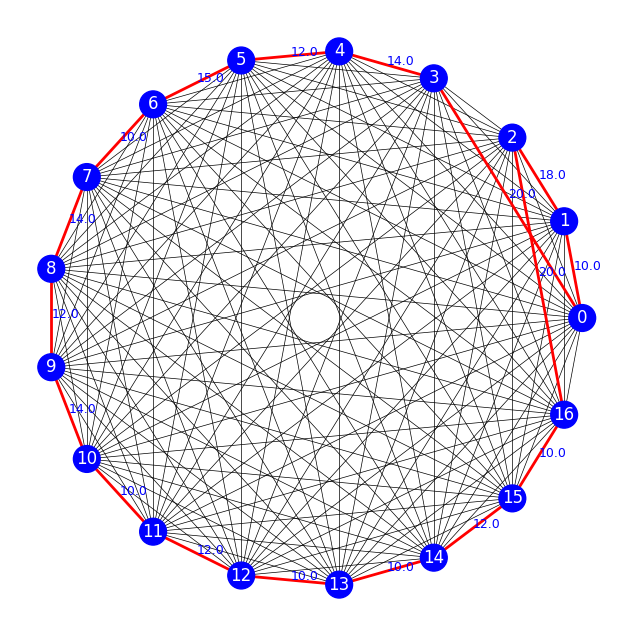

chemin avec 2-OPT : 


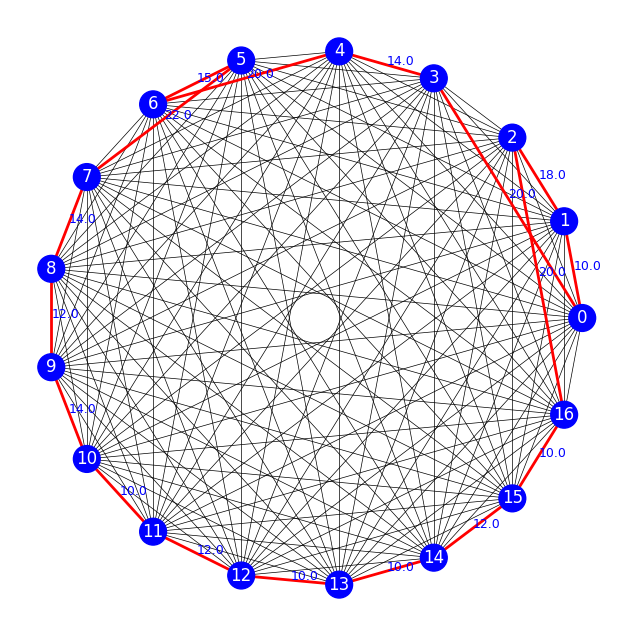

In [44]:
def generer_positions_circulaires(N):
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    return np.column_stack([np.cos(angles), np.sin(angles)])

def visualiser_graphe_et_chemin_optimal_avec_couts(matrice_distances, chemin_optimal):
    N = len(matrice_distances)
    positions = generer_positions_circulaires(N)

    fig, ax = plt.subplots(figsize=(8, 8))

    # Dessiner toutes les connexions en noir
    for i in range(N):
        for j in range(i + 1, N):
            start_pos, end_pos = positions[i], positions[j]
            ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]],
                    color='black', zorder=1, lw=0.5)

    # Dessiner le chemin optimal en rouge avec les coûts
    for i in range(len(chemin_optimal) - 1):
        start_pos, end_pos = positions[chemin_optimal[i]], positions[chemin_optimal[i + 1]]
        ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'ro-', zorder=2, lw=2)
        # Calcul du milieu de la ligne pour la position du texte
        mid_point = (start_pos + end_pos) / 2
        cout = matrice_distances[chemin_optimal[i], chemin_optimal[i + 1]]
        ax.text(mid_point[0], mid_point[1], f'{cout}', color='blue', fontsize=9, zorder=3)

    # Dessiner les nœuds
    for i, pos in enumerate(positions):
        ax.add_patch(plt.Circle(pos, 0.05, color='blue', zorder=4))
        ax.text(pos[0], pos[1], str(i), ha='center', va='center', color='white', fontsize=12, zorder=5)

    ax.set_aspect('equal')
    plt.axis('off')
    plt.show()

print("Chemin avec Branch and Bound:")
visualiser_graphe_et_chemin_optimal_avec_couts(matrice_distances, chemin_optimal)

print("chemin avec 2-OPT : ")
visualiser_graphe_et_chemin_optimal_avec_couts(matrice_distances, best_tour)

# **Comparaison  entre BnB, PPV, 2OPT :**  
Dans cette partie, nous allons comparer les performances des trois méthodes - Branch and Bound, Plus Proche Voisin et 2-opt - sur plusieurs ensembles de données en termes de temps d'exécution et de coût. Nous évaluerons chaque algorithme en fonction de sa capacité à trouver des solutions optimales ou proches de l'optimalité, ainsi que de sa vitesse d'exécution.  

Nous avons effectué un ensemble de 4 essais sur des datasets de tailles différentes et nous avons abouti à ce tableau comparatif en terme de temps  d'éxecution :  

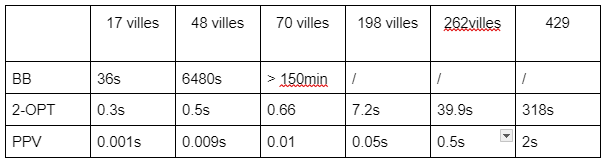  

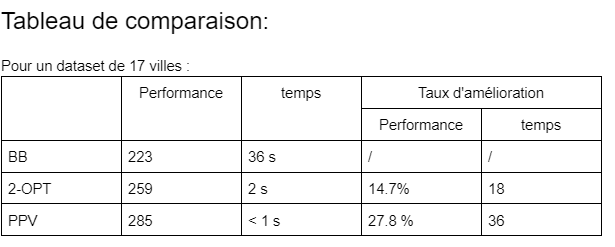

Pour mieux visualiser les résultats :  

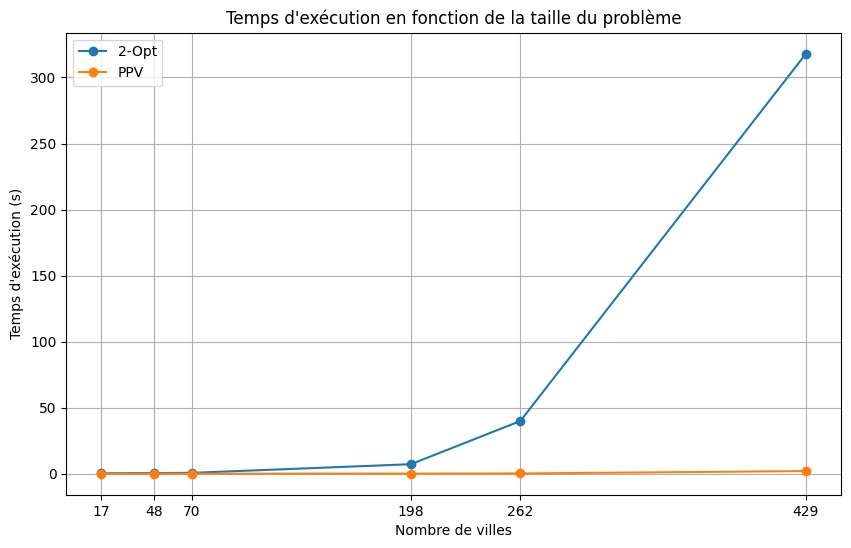

In [45]:
import matplotlib.pyplot as plt

# Tailles des problèmes
tailles_problemes = [17, 48, 70, 198, 262, 429]


# Temps d'exécution pour 2-Opt (en secondes)
temps_2opt = [0.3, 0.5, 0.66, 7.2, 39.9, 318]

# Temps d'exécution pour PPV (en secondes)
temps_ppv = [0.0001, 0.009, 0.01, 0.09, 0.19, 2]

# Création du graphique
plt.figure(figsize=(10, 6))


plt.plot(tailles_problemes, temps_2opt, marker='o', label='2-Opt')
plt.plot(tailles_problemes, temps_ppv, marker='o', label='PPV')

plt.title('Temps d\'exécution en fonction de la taille du problème')
plt.xlabel('Nombre de villes')
plt.ylabel('Temps d\'exécution (s)')
plt.grid(True)
plt.legend()
plt.xticks(tailles_problemes)

plt.show()


On remarque que l'heuristique du Plus Proche Voisin peut être relativement rapide même pour des datasets de 429 villes en raison de la simplicité des calculs et du nombre limité d'itérations nécessaires.  
Bien que la méthode du plus proche voisin implique le calcul de distances entre chaque paire de villes pour déterminer la plus proche, ce calcul est relativement simple par rapport à d'autres méthodes plus sophistiquées de résolution du TSP.  

donc on peut voir que pour des datasets de petite à moyenne taille, la méthode du plus proche voisin (PPV) est nettement plus rapide que l'optimisation 2-OPT. Cependant, à mesure que la taille du dataset augmente, 2-OPT devient relativement plus efficace en termes de qualité de la solution, même si le temps d'exécution augmente considérablement.

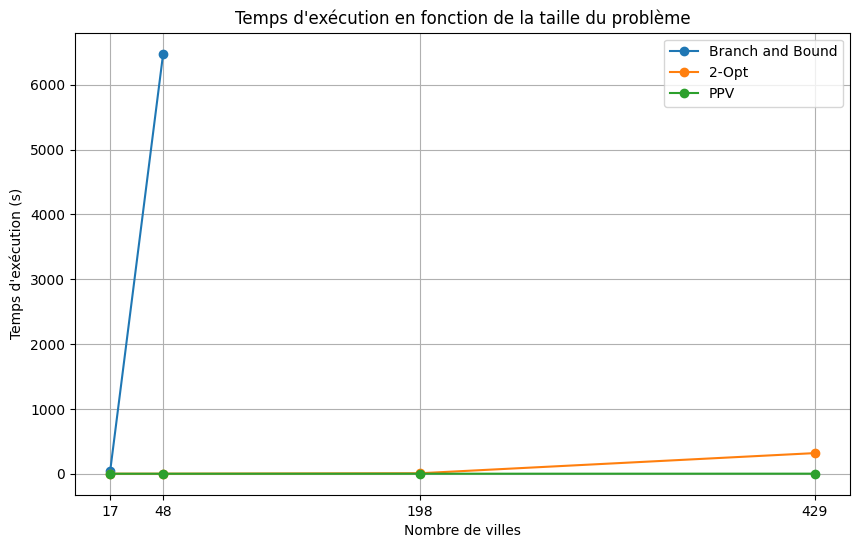

In [46]:
import matplotlib.pyplot as plt

# Tailles des problèmes
tailles_problemes = [17, 48, 198, 429]

# Temps d'exécution pour Branch and Bound (en secondes)
temps_bb = [36, 6480, None, None]  # Remplacer None pour les cas manquants

# Temps d'exécution pour 2-Opt (en secondes)
temps_2opt = [0.3, 0.5, 7.2, 318]

# Temps d'exécution pour PPV (en secondes)
temps_ppv = [0.009, 0.01, 0.19, 0.91]

# Création du graphique
plt.figure(figsize=(10, 6))

plt.plot(tailles_problemes, temps_bb, marker='o', label='Branch and Bound')
plt.plot(tailles_problemes, temps_2opt, marker='o', label='2-Opt')
plt.plot(tailles_problemes, temps_ppv, marker='o', label='PPV')

plt.title('Temps d\'exécution en fonction de la taille du problème')
plt.xlabel('Nombre de villes')
plt.ylabel('Temps d\'exécution (s)')
plt.grid(True)
plt.legend()
plt.xticks(tailles_problemes)

plt.show()


On peut observer que pour des datasets de petites à moyennes tailles, les deux heuristiques, PPV et 2-OPT, surpassent BB en termes de temps d'exécution. PPV est généralement beaucoup plus rapide, tandis que 2-OPT offre une amélioration significative de la qualité de la solution avec un temps d'exécution plus long mais encore raisonnable. Cependant, pour des datasets de taille plus importante, BB devient impraticable en raison de son temps d'exécution excessivement long, tandis que PPV et 2-OPT restent viables pour trouver des solutions de bonne qualité dans un temps raisonnable, même si elles ne sont pas nécessairement optimales.

# **Conclusion :**
En conclusion, l'algorithme de branch and bound (BB) offre la garantie de trouver la solution optimale au problème du voyageur de commerce (TSP), mais il devient rapidement impraticable en raison de son temps d'exécution excessivement long pour des datasets de taille moyenne à grande. En revanche, les heuristiques telles que la méthode du plus proche voisin (PPV) et l'optimisation 2-OPT offrent des temps d'exécution beaucoup plus courts, ce qui les rend plus adaptées pour des applications nécessitant des résultats rapidement, même s'ils ne sont pas nécessairement optimaux.